In [30]:
import sys
sys.path.insert(0, '/mnt/home/raheppt1/projects/MedicalDataAugmentationTool')
sys.path.insert(0, '/mnt/home/raheppt1/projects/age_prediction')

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from datasets.graph_dataset import GraphDataset
from datasources.cached_image_datasource import CachedImageDataSource
from datasources.label_datasource import LabelDatasource
from generators.image_generator import ImageGenerator
from generators.label_generator import LabelGenerator
from iterators.id_list_iterator import IdListIterator
from transformations.intensity.sitk.shift_scale_clamp import ShiftScaleClamp
import utils.sitk_image
from transformations.spatial import translation, composite, scale, rotation, flip, deformation

## Parameters

In [32]:
# Paths

# Data directory.
base_folder = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1'
# IDs in filenames are formatted with <id_digits> number of digits.
# e.g. ID=13 -> 0013 with id_digits=4.
id_digits = 3
file_prefix = 'fcmnorm_brain_mni_IXI'
file_suffix = '_T1_restore'
file_ext = '.nii.gz'

# csv file with ids of the training/validation images.
path_training_csv = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split0.csv'
path_validation_csv = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split0.csv'

# csv file with the age information for each subject.
path_info_csv = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_age.csv'
        
# Image parameters
dim = 3
image_size = [100, 120, 100] # [150, 180, 150]
image_spacing = [1.5, 1.5, 1.5]# [1.0, 1.0, 1.0]
shuffle_images = False

## Data augmentation

In [97]:
# Data augmentation / Image processing

def crop_pad(image):
    image = sitk.Crop(image, [0, 0, 0], [0, 0, 0])
    image = sitk.MirrorPad(image, [0, 0, 0], [0, 0, 0])
    return image

def post_processing_sitk_train(image):
    ssc = ShiftScaleClamp(shift=0.0,
                          scale=1.0,
                          clamp_min=0.0,
                          clamp_max=2.0,
                          random_scale=0.4,
                          random_shift=0.25)
    return ssc(image)

def post_processing_sitk_val(image):
    ssc = ShiftScaleClamp(shift=0.0,
                          scale=1.0,
                          clamp_min=0.0,
                          clamp_max=2.0)
    return ssc(image)

## Dataset utilities

In [98]:
def datasources(image_folder, label_csv, iterator):
    datasources_dict = {}
    # Loading sitk image from the following location:
    # image_folder/<file_prefix><id_dict_preprocessing(id_dict['image_id'])><file_suffix><file_ext>
    datasources_dict['image'] = CachedImageDataSource(image_folder,
                                                      file_prefix=file_prefix,
                                                      file_suffix=file_suffix,
                                                      file_ext=file_ext,
                                                      id_dict_preprocessing=lambda x: {
                                                          'image_id': str(x['image_id']).zfill(id_digits)},
                                                      preprocessing=crop_pad,
                                                      sitk_pixel_type=sitk.sitkFloat32,
                                                      cache_maxsize=24000,
                                                      name='image',
                                                      parents=[iterator])
    
    # Uses id_dict['image_id'] as the key for loading the label from a given .csv.
    # 'key_0', 'label_0'
    datasources_dict['age'] = LabelDatasource(label_csv, name='image', parents=[iterator])
    return datasources_dict

In [99]:
 def data_generators(dim, post_processing_sitk, transformation, data_sources):
        data_generator_dict = {}
        data_generator_dict['image'] = ImageGenerator(dim, image_size, image_spacing,
                                                      name='image',
                                                      post_processing_sitk=post_processing_sitk,
                                                      parents=[data_sources['image'], transformation],
                                                      resample_default_pixel_value=0.0)
        data_generator_dict['age'] = LabelGenerator(name='age', parents=[data_sources['age']])

        return data_generator_dict

In [118]:
# Define training images.
# csv "<id>, <subj>" -> OrderedDict ('image_id', '<id>'), ('unique_id', '<id><subj>')]
iterator = IdListIterator(path_training_csv, random=shuffle_images)

# Load image and label data.
sources = datasources(base_folder, path_info_csv, iterator)

transformation = composite.Composite(dim, [translation.InputCenterToOrigin(dim),
                                           flip.Random(dim, [0.5, 0.0, 0.0]),
                                           scale.Random(dim, [0.1, 0.1, 0.1]),
                                           translation.Random(dim, [10.0, 10.0, 10.0]),
                                           rotation.Random(dim, [0.1, 0.1, 0.1]),
                                           translation.OriginToOutputCenter(dim,
                                                                            image_size,
                                                                            image_spacing)],
                                            kwparents={'image': sources['image']})

#trf = composite.Composite(3, [trf_scale, trf_rot]).get()
#image = utils.sitk_image.resample(image, trf, image_size, default_pixel_value=-2.0)],
#                                     kwparents={'image': sources['image']})

generators = data_generators(dim,
                             post_processing_sitk_train,
                             transformation,
                             sources)

dataset = GraphDataset(data_sources=list(sources.values()),
                       data_generators=list(generators.values()),
                       iterator=iterator)

loaded 410 ids


## Testing / Visualization

In [126]:
from mpl_toolkits.axes_grid1 import ImageGrid
def vis_brain_grid(image, axis_sel=0, n_slices=9, normalize=True, vmin=0.0, vmax=2.0):
    # n_slices should me a multiple of three.
    max_slices = image.shape[axis_sel+1]
    if normalize:
        image = (image - np.mean(image))/(np.std(image))
        
    image = image[0,...]
    if axis_sel == 1:
        image = image.transpose([1, 2 , 0])
    elif axis_sel == 2:
        image = image.transpose([2, 0, 1])
    
    image_list = [image[max_slices//n_slices*k, : , :] for k in range(n_slices)]
    
    fig = plt.figure(figsize=(15., 15.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, image_list):
        ax.imshow(im, cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
    plt.show()
    
def vis_brain(image, slice_sel, axis_sel=1, normalize=False, vmin=None, vmax=None):
    if normalize:
        image = (image - np.mean(image))/(np.std(image))
    
    image = image[0,...]
    if axis_sel == 1:
        image = image.transpose([1, 2 , 0])
    elif axis_sel == 2:
        image = image.transpose([2, 0, 1])
    
    fig = plt.figure(figsize=(10., 10.))
    if not vmin or not vmax:
        plt.imshow(image[slice_sel, :, :], cmap='gray')
    else:
        plt.imshow(image[slice_sel, :, :], cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.show()


Display multiple slices for a **single sample**:

id: 023 | subject age: [33.078712] | image size: (1, 100, 120, 100) 


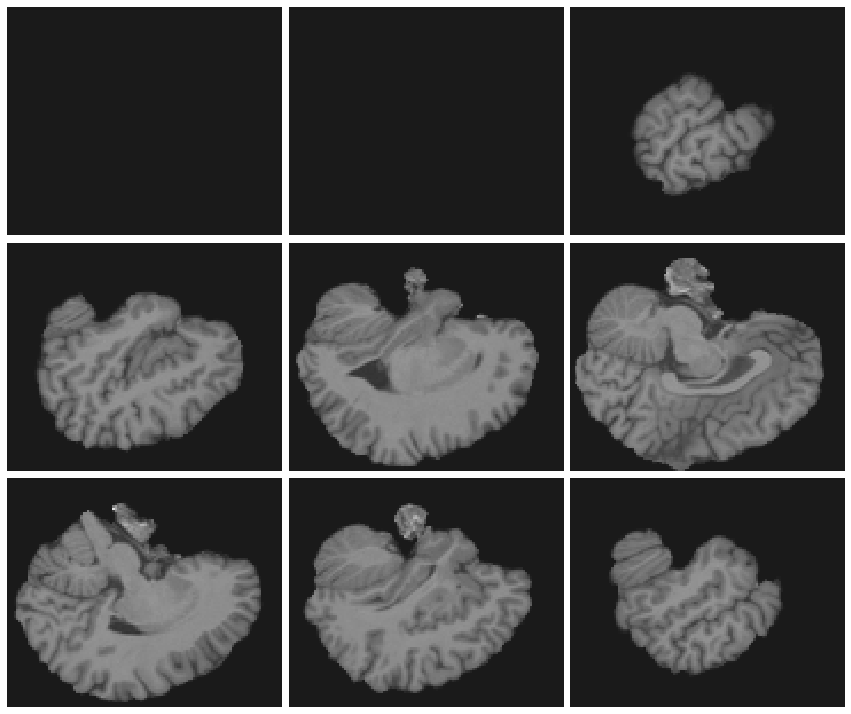

In [129]:
sample = dataset.get_next()
image = sample['generators']['image']
print(f"id: {sample['id']['image_id']} | subject age: {sample['generators']['age']} | image size: {image.shape} ")

vis_brain_grid(image, axis_sel=2, normalize=False, vmin=0.0, vmax=2.0)

Display single slice for a **mutliple samples**:

id: 024 | subject age: [37.697468] | image size: (1, 100, 120, 100) 


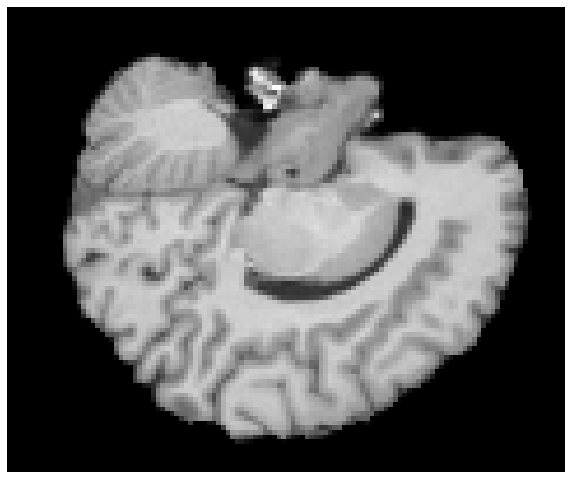

In [130]:
n_samples = 1

for _ in range(n_samples):
    sample = dataset.get_next()
    image = sample['generators']['image']
    print(f"id: {sample['id']['image_id']} | subject age: {sample['generators']['age']} | image size: {image.shape} ")

    #vis_brain_grid(image, axis_sel=1, normalize=False)
    vis_brain(image, slice_sel=60, axis_sel=2, normalize=False, vmin=0.0, vmax=2.0)